# Prematch function in SLAT
SLAT provides a lot of methods to make use of prior, such as 
- Expert prior
- H&E images
- Tissue shape

The third one is the most basic which you can use in every dataset. In detail, we see cells in 2D as point cloud and then the ICP (Iterative Closest Point) to register them.


In [1]:
import cv2
import numpy as np
import copy
import sklearn.neighbors
import scipy.optimize
import scanpy as sc
import random
from matplotlib.pyplot import *
import matplotlib.pyplot
from matplotlib import pyplot as plt
from itertools import chain

from scSLAT.model.prematch import icp, alpha_shape, rotate_via_numpy
from scSLAT.viz import hist

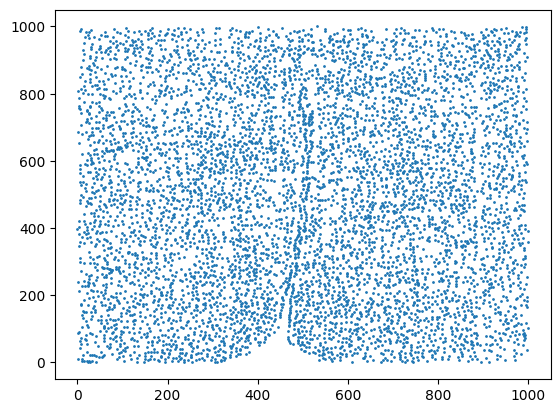

Rotation 40.10704565915762 degree


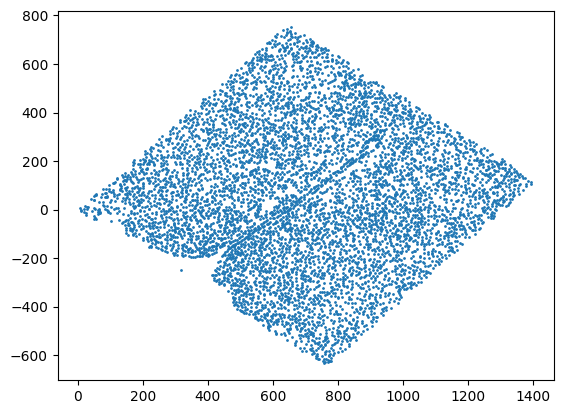

In [3]:
merfish1 = sc.read_h5ad('../../data/merfish/hypothalamic/merfish_layer1_labeled.h5ad')
spatial_info1 = merfish1.obsm['spatial']
plt.scatter(spatial_info1[:,0], spatial_info1[:,1], s=1)
plt.show()

merfish2 = sc.read_h5ad('../../data/merfish/hypothalamic/merfish_layer2_labeled.h5ad')
spatial_info2 = merfish2.obsm['spatial']
spatial_info2 = rotate_via_numpy(spatial_info2,0.7) # we rotate the cells coordinate in dataset 2
plt.scatter(spatial_info2[:,0], spatial_info2[:,1], s=1)
plt.show()

/tmp/ipykernel_3616393/3945006097.py:2: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  boundary_1, edges_1, _ = alpha_shape(spatial_info1, alpha=alpha, only_outer=True)


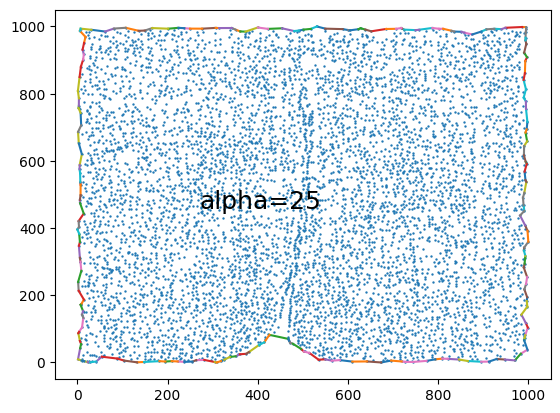

/tmp/ipykernel_3616393/3945006097.py:10: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  boundary_2, edges_2, _ = alpha_shape(spatial_info2, alpha=alpha, only_outer=True)


Text(270.5, 459, 'alpha=25')

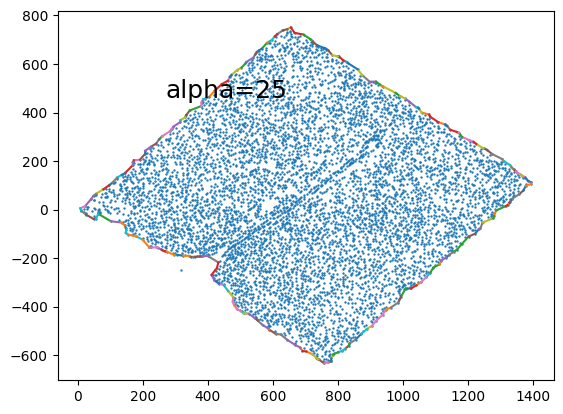

In [5]:
alpha = 25
boundary_1, edges_1, _ = alpha_shape(spatial_info1, alpha=alpha, only_outer=True)
plt.scatter(spatial_info1[:, 0], spatial_info1[:, 1], s = 0.5)
for i, j in edges_1:
    plt.plot(spatial_info1[[i, j], 0], spatial_info1[[i, j], 1])

plt.text(270.5,459, f"alpha={alpha}", size=18)
plt.show()

boundary_2, edges_2, _ = alpha_shape(spatial_info2, alpha=alpha, only_outer=True)
plt.scatter(spatial_info2[:, 0], spatial_info2[:, 1], s = 0.5)
for i, j in edges_2:
    plt.plot(spatial_info2[[i, j], 0], spatial_info2[[i, j], 1])

plt.text(270.5,459, f"alpha={alpha}", size=18)

Use ICP to register

In [6]:
T, error = icp(spatial_info2[boundary_2,:].T,spatial_info1[boundary_1,:].T)
dx = T[0,2]
dy = T[1,2]
rotation = np.arcsin(T[0,1]) * 360 / 2 / np.pi

print("T",T)
print("error",error)
print("rotation°",rotation)

src (1, 225, 2)
Tr[0:2] (2, 3)
T [[  0.75988392  -0.65005879   3.17847926]
 [  0.65005879   0.75988392 -13.56173822]
 [  0.           0.           1.        ]]
error 37571.443135075606
rotation° -40.54603416224576


At last we adjust the coordinates of dataset2, so two datasets have been pre-matched now! 

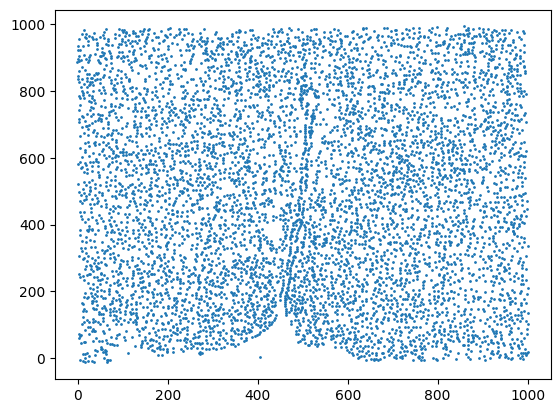

In [7]:
trans = np.squeeze(cv2.transform(np.array([spatial_info2], copy=True).astype(np.float32), T))[:,:2]
merfish2.obsm['spatial'] = trans
plt.scatter(trans[:,0], trans[:,1],s=1)
plt.show()